In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weather-dataset-rattle-package:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6012%2F1733506%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T000822Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c3f3bfa1cc6516cb6ec46ee5f3765b6cda67e33eb319ef15aa6848381344154693ef4d324206765abdfe1d1831428267c78dc0b327e525aec8cc145dd531fe45ef114686dfc0c5ca6f95c96242876506e5adbac7d464d39e0e353db57b784e8c39d57b551c8a6a721d9f8f78d3baa83fc2442d4a809b68711ca6ea095fb6274018c6c7d1a6ef33d14b5da21744b162fd9444cb1a476a072520925ecde956e5ce667be192c701288a6c7c6d35931bf8b833094e7260c55abafceaced28b34dca23232914f2ba2125043ac5c862230bc0bc00e584e2a6193453444af5be97ec1aa7a3f6b9856955e85c397c8c948af903f402ed1e82a65893568297144253a2ce'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4020790 bytes downloaded
Downloaded and uncompressed: weather-dataset-rattle-package
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Exploratory Data Analysis

### Dataframe Information

* There are categorical (object) and numerical (float64) features.
* There are missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Categorical Features

In [5]:
df.select_dtypes(['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

### Date

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df['Date'].isnull().sum()

0

In [8]:
Date = df['Date'].value_counts()

Date.transpose()

Date
2013-11-12    49
2014-09-01    49
2014-08-23    49
2014-08-24    49
2014-08-25    49
              ..
2007-11-29     1
2007-11-28     1
2007-11-27     1
2007-11-26     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64

In [9]:
df['Month'] = df['Date'].dt.month

df['Day'] = df['Date'].dt.day

In [10]:
Month = df['Month'].value_counts()

Month.transpose()

Month
3     13361
5     13353
1     13236
6     12684
8     12028
10    12028
7     12025
11    11669
9     11640
4     11550
12    11093
2     10793
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

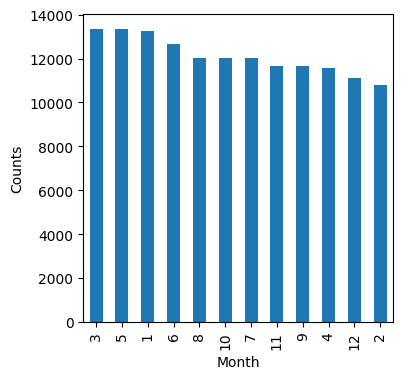

In [11]:
ax = Month.plot.bar(figsize = (4,4), label = False)

ax.set_xlabel('Month')
ax.set_ylabel('Counts')

In [12]:
Day = df['Day'].value_counts()

Day.transpose()

Day
1     4786
13    4786
23    4786
22    4786
21    4786
20    4786
19    4786
18    4786
17    4786
2     4786
15    4786
14    4786
16    4786
12    4786
6     4786
11    4786
4     4786
5     4786
3     4786
7     4786
8     4786
9     4786
10    4786
24    4785
25    4784
26    4736
27    4735
28    4735
29    4449
30    4351
31    2807
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

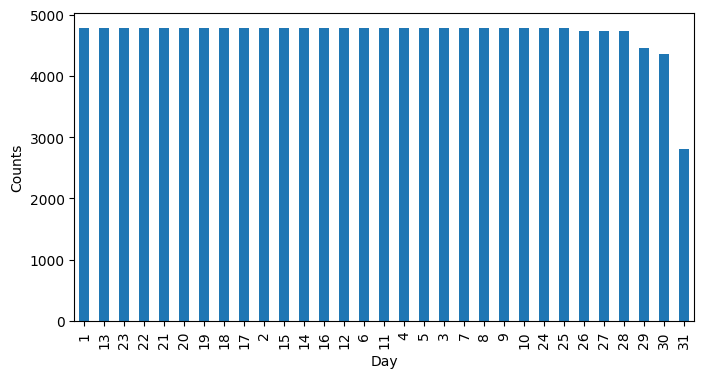

In [13]:
ax = Day.plot.bar(figsize = (8,4), label = False)

ax.set_xlabel('Day')
ax.set_ylabel('Counts')

### Location

* The location with more apperea Canbera with 3436.
* There are not missing values.

In [14]:
df['Location'].isnull().sum()

0

In [15]:
location = df['Location'].value_counts()

location.transpose()

Location
Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nuriootpa           3009
Cobar               3009
CoffsHarbour        3009
Moree               3009
Sale                3009
PerthAirport        3009
PearceRAAF          3009
Witchcliffe         3009
BadgerysCreek       3009
Mildura             3009
NorfolkIsland       3009
MelbourneAirport    3009
Richmond            3009
SydneyAirport       3009
WaggaWagga          3009
Williamtown     

Text(0.5, 0, 'Location')

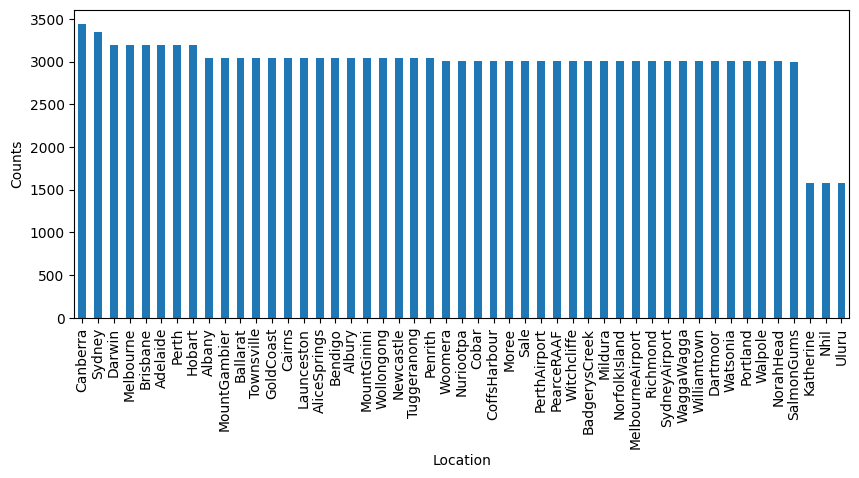

In [16]:
ax = location.transpose().plot.bar(figsize = (10,4), legend = False)
ax.set_ylabel('Counts')
ax.set_xlabel('Location')

### WindGustDir  

* There are missing values, 10326 in total.
* The wind direction with more appereance is W, with 9915.

In [17]:
df['WindGustDir'].isnull().sum()

10326

In [18]:
WindGustDir = df['WindGustDir'].value_counts()

WindGustDir.transpose()

WindGustDir
W      9915
SE     9418
N      9313
SSE    9216
E      9181
S      9168
WSW    9069
SW     8967
SSW    8736
WNW    8252
NW     8122
ENE    8104
ESE    7372
NE     7133
NNW    6620
NNE    6548
Name: count, dtype: int64

Text(0.5, 0, 'WindGustDir')

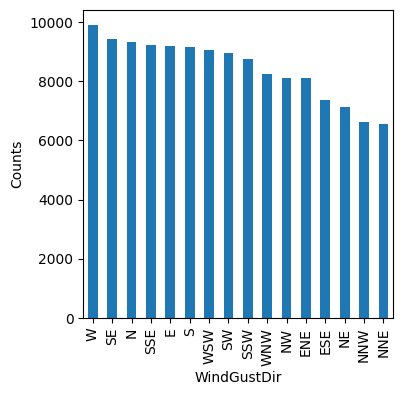

In [19]:
ax = WindGustDir.transpose().plot.bar(figsize = (4,4), legend = False)
ax.set_ylabel('Counts')
ax.set_xlabel('WindGustDir')

### WindDir9am

* There ar missing values, 10566.
* The wind direction 9am with most appereance is N, a different direction compare with WindGustDir.

In [20]:
df['WindDir9am'].isnull().sum()

10566

In [21]:
WindDir9am = df['WindDir9am'].value_counts()

WindDir9am.transpose()

WindDir9am
N      11758
SE      9287
E       9176
SSE     9112
NW      8749
S       8659
W       8459
SW      8423
NNE     8129
NNW     7980
ENE     7836
NE      7671
ESE     7630
SSW     7587
WNW     7414
WSW     7024
Name: count, dtype: int64

Text(0.5, 0, 'WindDir9am')

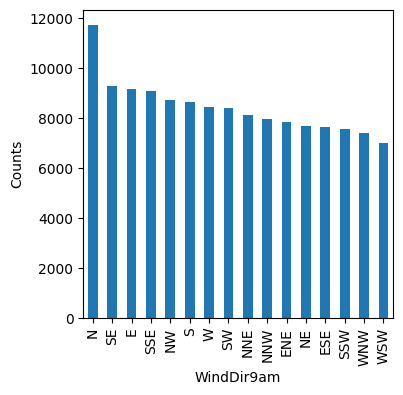

In [22]:
ax = WindDir9am.plot.bar(figsize = (4,4), label = False)
ax.set_ylabel('Counts')
ax.set_xlabel('WindDir9am')

### WindDir3pm

* There are missing values, 4228.
* The most common wind direction 3pm is SE, a different one compare with the previous two wind directions.

In [23]:
df['WindDir3pm'].isnull().sum()

4228

In [24]:
WindDir3pm = df['WindDir3pm'].value_counts()

WindDir3pm.transpose()

WindDir3pm
SE     10838
W      10110
S       9926
WSW     9518
SSE     9399
SW      9354
N       8890
WNW     8874
NW      8610
ESE     8505
E       8472
NE      8263
SSW     8156
NNW     7870
ENE     7857
NNE     6590
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

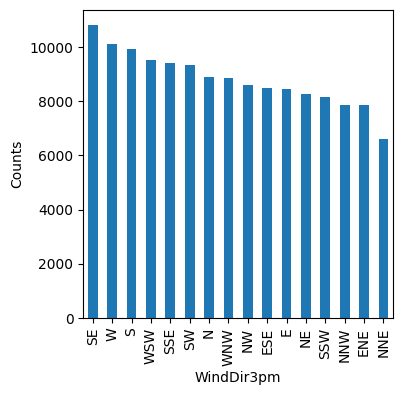

In [25]:
ax = WindDir3pm.plot.bar(figsize = (4,4), label = False)

ax.set_xlabel('WindDir3pm')
ax.set_ylabel('Counts')

### RainToday

* There are missing values, 3261.
* The most common data is that there is no rain.

In [26]:
df['RainToday'].isnull().sum()

3261

In [27]:
RainToday = df['RainToday'].value_counts()

RainToday.transpose()

RainToday
No     110319
Yes     31880
Name: count, dtype: int64

Text(0.5, 0, 'RainToday')

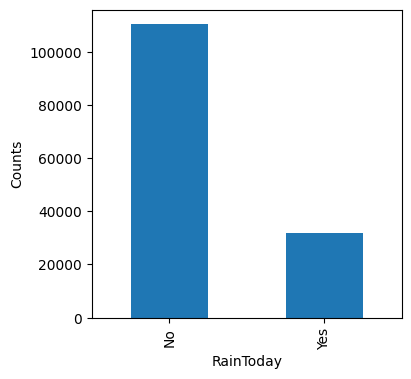

In [28]:
ax = RainToday.plot.bar(figsize = (4,4), label = False)
ax.set_ylabel('Counts')
ax.set_xlabel('RainToday')

### RainTomorrow

* There are missing values, 3267.
* No rain is the most appereance value.

In [29]:
df['RainTomorrow'].isnull().sum()

3267

In [30]:
RainTomorrow = df['RainTomorrow'].value_counts()

RainTomorrow.transpose()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

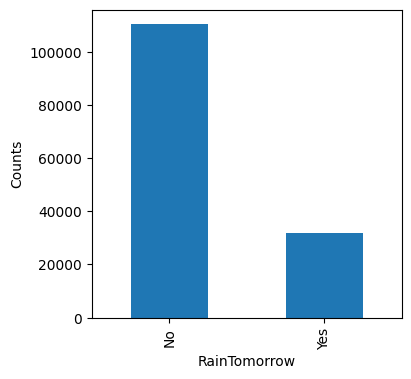

In [31]:
ax = RainTomorrow.plot.bar(figsize = (4,4), label = False)
ax.set_xlabel('RainTomorrow')
ax.set_ylabel('Counts')

## Numerical Data

In [32]:
Numerical = list(df.select_dtypes(['float64']).columns)

In [33]:
df[Numerical].isnull().sum()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
dtype: int64

In [41]:
list_group = []

for i in range(0, len(Numerical),3):
    list_group.append(Numerical[i:i+3])

In [51]:
df['MinTemp'].min()

-8.5

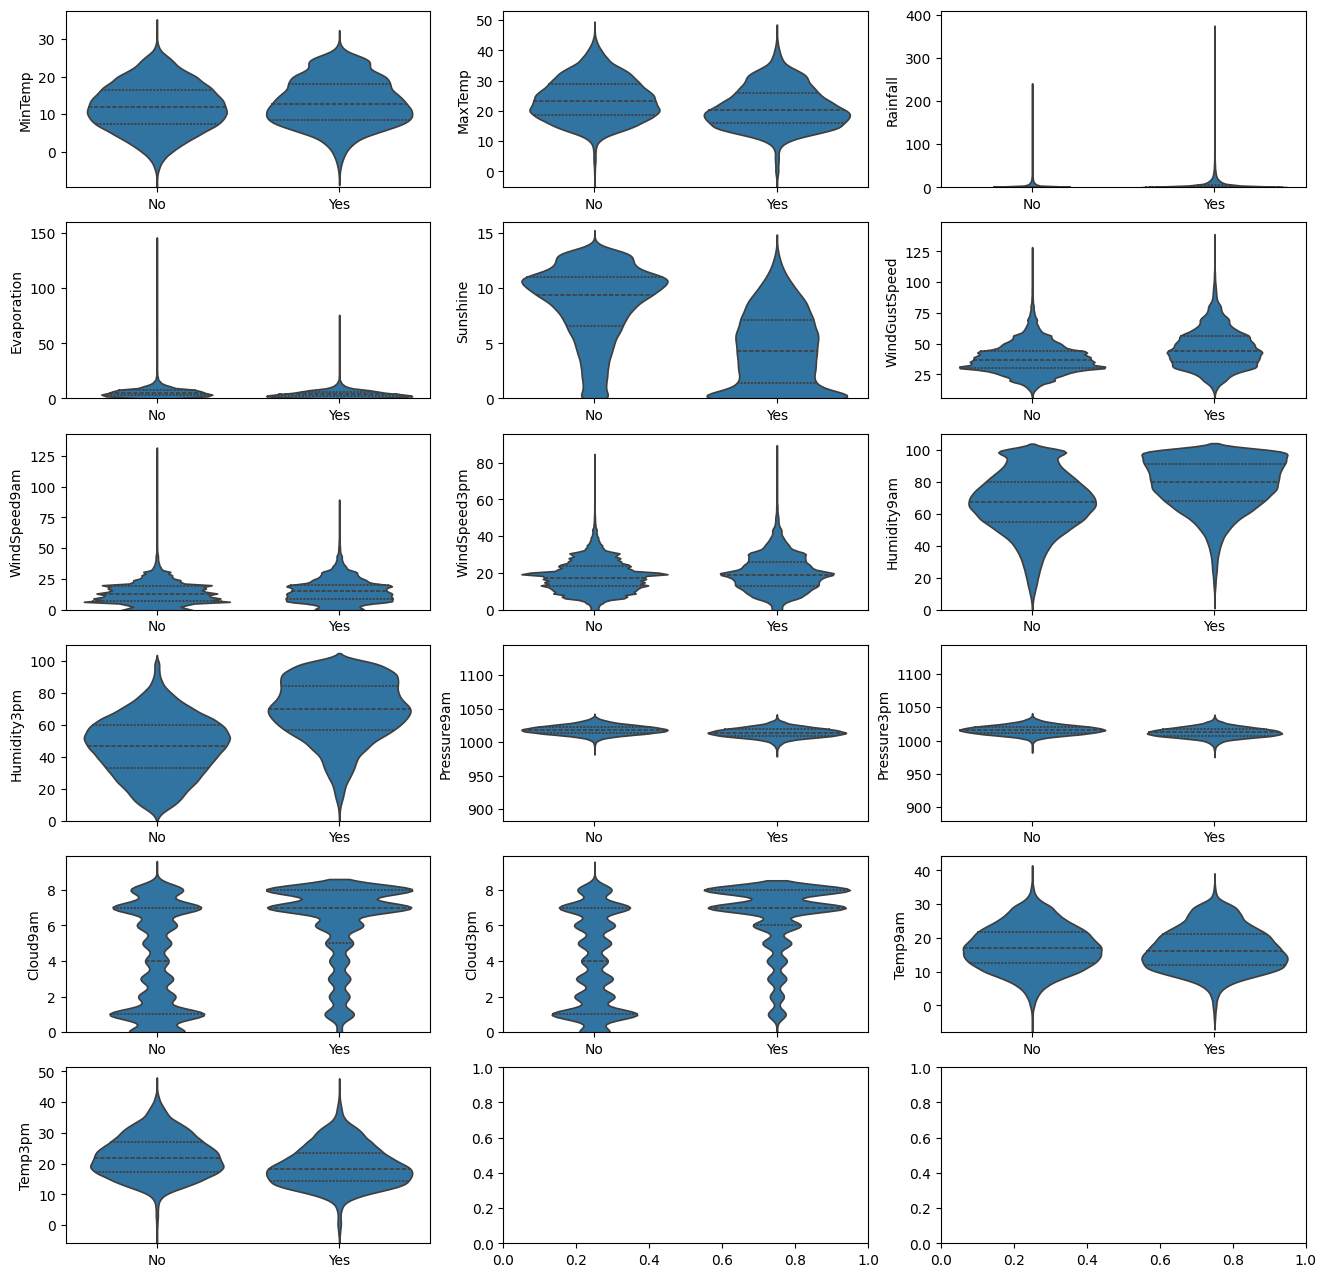

In [60]:
fig, axs = plt.subplots(ncols=3, nrows = 6, figsize=(16, 16))

cont = 0

for pack in list_group:

    for i in range(len(pack)):
        #print(cont,i)
        column = pack[i]
        sns.violinplot(x = df['RainTomorrow'], y = df[column], inner= 'quartile', ax = axs[cont][i])
        axs[cont][i].set_xlabel('')
        axs[cont][i].set_ylabel(column)
        axs[cont][i].set_ylim(df[column].min() - abs(df[column].min()) * 0.1 , df[column].max() + df[column].max() * 0.1)

    cont+=1
